In [60]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Read data from CSV files
bcwlist = pd.read_excel('data/bcwlist.xlsx', skiprows=2)
crsp = pd.read_csv('data/cleaned_crsp.csv')

# Convert date columns to datetime format
crsp['date'] = pd.to_datetime(crsp['date'])

# Convert RET and PRC columns to numeric data types and handle invalid values
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')

# Group by date and permno, and aggregate using the last valid observation
crsp = crsp.groupby(['PERMNO', pd.Grouper(key='date', freq='M')]).last().reset_index()

import warnings
warnings.filterwarnings('ignore')

In [64]:
# Function to calculate weights for equal- and value-weighted portfolios
def get_weights(data, weight_type):
    if weight_type == 'equal':
        weights = np.ones(len(data)) / len(data)
    elif weight_type == 'value':
        weights = data['SHROUT'] * data['PRC']
        weights /= weights.sum()
    return weights

# Function to calculate monthly returns for the portfolio
def calculate_monthly_returns(data, weights):
    returns = (data['RET'] * weights).sum()
    return returns

In [67]:
def build_portfolios(bcwlist, crsp):
    portfolio_returns = {'equal': [], 'value': []}
    # Get the unique years in bcwlist
    years = bcwlist['year'].unique()
    years = sorted(years, key=lambda year: int(year))
    print(years)

    for i in tqdm(range(len(years) - 1)):
        start_date = pd.Timestamp(year=years[i], month=1, day=1)
        end_date = pd.Timestamp(year=years[i + 1], month=1, day=1)

        period_bcws = bcwlist[bcwlist['year'] == start_date.year]

        for weight_type in ['equal', 'value']:
            portfolio_value = 1
            portfolio_value_history = []

            # Get the list of companies for the current year
            companies = period_bcws['permno'].values
            companies = companies[~np.isnan(companies)]

            prev_date = start_date + pd.DateOffset(months=1, days=-1)
            for date in pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date + pd.DateOffset(months=1), freq='M'):

                existing_companies = crsp[(crsp['date'] == prev_date)]['PERMNO'].unique()

                # Remove any companies from the companies list that are not present in matching_companies
                cur_companies = np.intersect1d(companies, existing_companies)

                stock_data = crsp[(crsp['date'] == date) & crsp['PERMNO'].isin(cur_companies)]

                if not stock_data.empty:
                    # Calculate weights
                    weights = get_weights(stock_data, weight_type)
                    # Calculate monthly returns
                    stock_data['monthly_return'] = stock_data['RET'] * weights

                    # Add new stocks and remove delisted stocks
                    stock_data = stock_data.dropna(subset=['monthly_return'])

                    # Calculate portfolio value and store the value history
                    portfolio_value *= (1 + stock_data['monthly_return'].sum())
                    portfolio_value_history.append(portfolio_value)

                # Get stock data closest to the current date
                # stock_data = period_crsp[(period_crsp['date'] == date + pd.DateOffset(months=1)) & period_crsp['PERMNO'].isin(companies)]
                prev_date = date

            portfolio_returns[weight_type].append(pd.DataFrame(portfolio_value_history, columns=['return'], index=pd.date_range(start=start_date + pd.DateOffset(months=1), end=end_date + pd.DateOffset(months=1), freq='M').to_period('M')))

    # Concatenate dataframes
    for weight_type in ['equal', 'value']:
        portfolio_returns[weight_type] = pd.concat(portfolio_returns[weight_type])

    return portfolio_returns

# Build the portfolios and calculate returns
portfolios = build_portfolios(bcwlist, crsp)

for portfolio in portfolios:
    portfolios[portfolio]['return'] -= 1
    print(portfolios[portfolio])

[1984, 1993, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


100%|██████████| 24/24 [00:39<00:00,  1.65s/it]

           return
1984-02 -0.067367
1984-03 -0.061750
1984-04 -0.060402
1984-05 -0.116600
1984-06 -0.070306
...           ...
2019-09  0.077492
2019-10  0.091240
2019-11  0.146572
2019-12  0.162250
2020-01  0.170103

[432 rows x 1 columns]
           return
1984-02 -0.041236
1984-03 -0.026735
1984-04 -0.001880
1984-05 -0.044939
1984-06 -0.029888
...           ...
2019-09  0.099688
2019-10  0.133911
2019-11  0.186772
2019-12  0.229321
2020-01  0.235520

[432 rows x 1 columns]


In [68]:
portfolios['equal'].describe()

,return
count,432.000000
mean,0.357225
std,0.530371
min,-0.390194
25%,0.024265
50%,0.126774
75%,0.570208
max,2.375947


In [69]:
import pandas_datareader as pdr

ff3 = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1984-02', end='2020-01')[0]
ff5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1984-02', end='2020-01')[0]
ff3 = ff3 / 100
ff5 = ff5 / 100

In [70]:
def calculate_statistics(portfolio_returns):
    avg_monthly_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()
    sharpe_ratio = avg_monthly_return / volatility
    return avg_monthly_return, volatility, sharpe_ratio

for weight_type in ['equal', 'value']:
    avg_monthly_return, volatility, sharpe_ratio = calculate_statistics(portfolios[weight_type]['return'])
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print(f"Average Monthly Return: {avg_monthly_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print()


Equal Weighted Portfolio:
Average Monthly Return: 0.3572
Volatility: 0.5304
Sharpe Ratio: 0.6735

Value Weighted Portfolio:
Average Monthly Return: 0.5277
Volatility: 0.8360
Sharpe Ratio: 0.6313



In [71]:
from statsmodels.api import OLS
from statsmodels.tools import add_constant

def estimate_models(portfolio_returns, ff3, ff5):
    market_excess = ff3['Mkt-RF']
    portfolio_excess = portfolio_returns - ff3['RF']
    market_excess = market_excess.loc[portfolio_excess.index]

    print(portfolio_excess.isna().sum())

    # CAPM Model
    X = add_constant(market_excess)
    capm_model = OLS(portfolio_excess, X).fit()

    # FF3 Model
    X = add_constant(ff3[['Mkt-RF', 'SMB', 'HML']].loc[portfolio_excess.index])
    ff3_model = OLS(portfolio_excess, X).fit()

    # Carhart Model
    X = add_constant(ff3.loc[portfolio_excess.index].join(ff5['RMW']).join(ff5['CMA']))
    carhart_model = OLS(portfolio_excess, X).fit()

    # FF5 Model
    X = add_constant(ff5.loc[portfolio_excess.index])
    ff5_model = OLS(portfolio_excess, X).fit()

    return capm_model, ff3_model, carhart_model, ff5_model

for weight_type in ['equal', 'value']:
    capm_model, ff3_model, carhart_model, ff5_model = estimate_models(portfolios[weight_type]['return'], ff3, ff5)
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print("CAPM Model summary:")
    print(capm_model.summary())
    print("FF3 Model summary:")
    print(ff3_model.summary())
    print("Carhart Model summary:")
    print(carhart_model.summary())
    print("FF5 Model summary:")
    print(ff5_model.summary())
    print()

0
Equal Weighted Portfolio:
CAPM Model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     8.254
Date:                Fri, 28 Apr 2023   Prob (F-statistic):            0.00427
Time:                        20:02:48   Log-Likelihood:                -333.70
No. Observations:                 432   AIC:                             671.4
Df Residuals:                     430   BIC:                             679.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [72]:
portfolios['equal']['return'].max()

2.3759465663524835

In [73]:
portfolios['value']['return'].min()

-0.3323347255007453

0


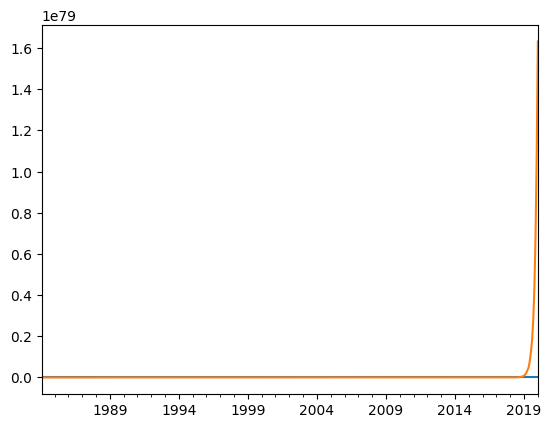

In [74]:
import matplotlib.pyplot as plt


def plot_cumulative_returns(portfolio_returns, capm_model, ff3):
    expected_returns = capm_model.predict(add_constant(ff3['Mkt-RF'].loc[portfolio_returns.index])) + ff3['RF'].loc[portfolio_returns.index]
    cum_portfolio_returns = (1 + portfolio_returns).cumprod()
    cum_portfolio_returns.plot()
    cum_expected_returns = (1 + expected_returns).cumprod()
    cum_expected_returns.plot()

    # plt.figure(figsize=(12, 6))
    # plt.plot(cum_portfolio_returns, label='Value-weighted Portfolio')
    # plt.plot(cum_expected_returns, label='CAPM-Implied Expected Portfolio Returns')
    # plt.xlabel('Year')
    # plt.ylabel('Cumulative Returns')
    # plt.legend()
    # plt.show()

capm_model_value_weighted, _, _, _ = estimate_models(portfolios['value']['return'], ff3, ff5)
plot_cumulative_returns(portfolios['value']['return'], capm_model_value_weighted, ff3)

In [78]:
def estimate_carhart_subsamples(portfolio_returns, ff3, ff5, date_split):
    pre_returns = portfolio_returns.loc[:date_split]
    post_returns = portfolio_returns.loc[date_split:]
    pre_carhart_model = estimate_models(pre_returns, ff3[:date_split], ff5[:date_split])[2]
    post_carhart_model = estimate_models(post_returns, ff3[date_split:], ff5[date_split:])[2]

    print("Carhart Model (Pre-January 1st, 2010):")
    print(pre_carhart_model.summary())
    print("Carhart Model (Post-January 1st, 2010):")
    print(post_carhart_model.summary())

estimate_carhart_subsamples(portfolios['value']['return'], ff3, ff5, '2010-01-01')

0
0
Carhart Model (Pre-January 1st, 2010):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     5.429
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           2.37e-05
Time:                        20:04:30   Log-Likelihood:                -403.56
No. Observations:                 312   AIC:                             821.1
Df Residuals:                     305   BIC:                             847.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    